In [ ]:
#LSTM

- Multi-Input LSTM Model: The LSTM model processes the previous VIX values, and a separate Dense layer processes the topic vectors. These two are concatenated and used for the final prediction.
- Custom Grid Search: The custom function grid_search_lstm performs grid search to find the best hyperparameters.
- Training and Testing Split: The code ensures the train/test split respects the temporal order of the data.
- Plotting: The code includes plotting the train/test split and the actual vs predicted values for visualization.

/var/folders/06/4lfc08752zv_l79gm6nmv18w0000gn/T/ipykernel_82355/2189927269.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])


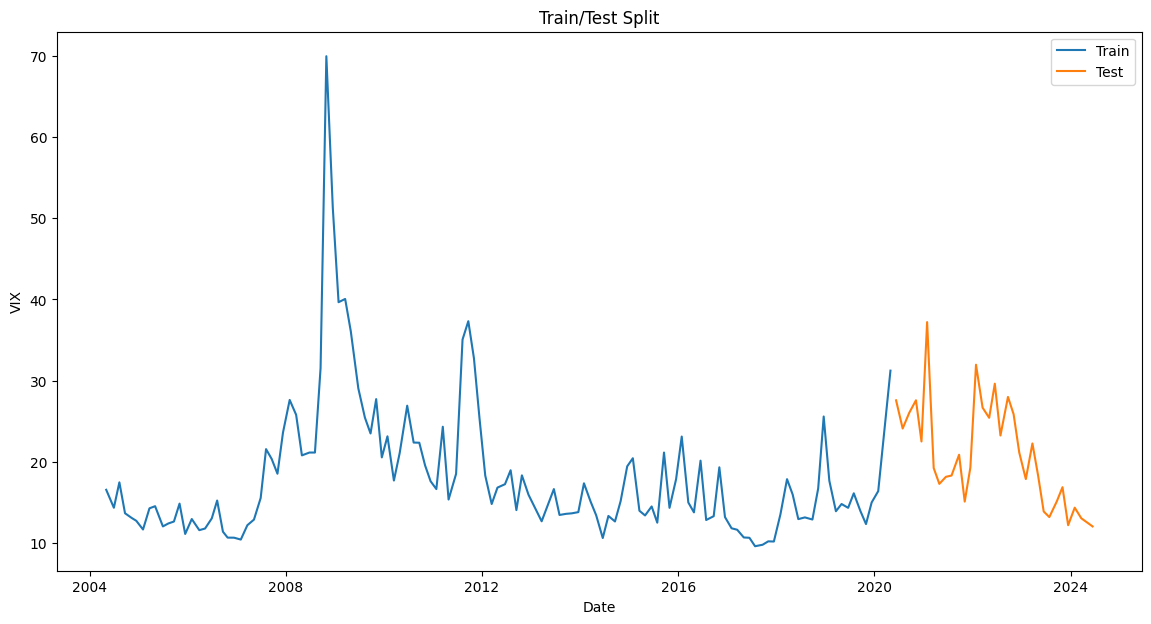

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, concatenate

# Load the datasets
sentiment_data = pd.read_csv('Final Sentiment by Topic.csv')
vix_data = pd.read_csv('vix_data.csv')

# Convert the date columns to datetime format
sentiment_data['month'] = pd.to_datetime(sentiment_data['month'])
sentiment_data['file_id'] = pd.to_datetime(sentiment_data['file_id'], format='%Y%m%d')
vix_data['DATE'] = pd.to_datetime(vix_data['DATE'])

# Create lagged features for each of the topic vectors and the previous VIX value
for column in sentiment_data.columns[3:]:
    sentiment_data[f'{column}_lag_1'] = sentiment_data[column].shift(1)

# Merge the datasets based on 'file_id' and 'DATE'
merged_data = pd.merge(sentiment_data, vix_data, left_on='file_id', right_on='DATE', how='left')

# Drop unnecessary columns and rows with missing values
merged_data.drop(columns=['category_id', 'DATE'], inplace=True)
merged_data.dropna(inplace=True)

# Create the previous VIX value column
merged_data['VIX_lag_1'] = merged_data['CLOSE'].shift(1)
merged_data.dropna(inplace=True)

# Define the features (X) and target (y) with the lagged features included
vix_columns = ['VIX_lag_1']
topic_columns = ['Quarterly Economic Performance', 'Committee Deliberations and Policies',
                 'Inflation and Prices', 'Economic Growth and Business Activity',
                 'Credit Markets and Financial Conditions', 'Economic Forecasts and Projections',
                 'Quarterly Economic Performance_lag_1', 'Committee Deliberations and Policies_lag_1',
                 'Inflation and Prices_lag_1', 'Economic Growth and Business Activity_lag_1',
                 'Credit Markets and Financial Conditions_lag_1', 'Economic Forecasts and Projections_lag_1']

X_vix = merged_data[vix_columns]
X_topics = merged_data[topic_columns]
y = merged_data['CLOSE']

# Scale the data
scaler_vix = MinMaxScaler()
X_vix_scaled = scaler_vix.fit_transform(X_vix)

scaler_topics = MinMaxScaler()
X_topics_scaled = scaler_topics.fit_transform(X_topics)

# Reshape the data for LSTM [samples, timesteps, features]
X_vix_lstm = X_vix_scaled.reshape((X_vix_scaled.shape[0], 1, X_vix_scaled.shape[1]))
X_topics_lstm = X_topics_scaled

# Train-test split while respecting the temporal order
split_index = int(len(X_vix_lstm) * 0.8)
X_vix_train, X_vix_test = X_vix_lstm[:split_index], X_vix_lstm[split_index:]
X_topics_train, X_topics_test = X_topics_lstm[:split_index], X_topics_lstm[split_index:]
y_train, y_test = y[:split_index].values, y[split_index:].values  # Convert y to numpy arrays

# Plot the train/test split
plt.figure(figsize=(14, 7))
plt.plot(merged_data['file_id'][:split_index], y_train, label='Train')
plt.plot(merged_data['file_id'][split_index:], y_test, label='Test')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Train/Test Split')
plt.legend()
plt.show()

2/2 [==============================] - 0s 3ms/step
Best parameters: {'neurons': 100, 'dropout_rate': 0.2, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 100}
Best score (RMSE): 8.749186042466045
1/1 [==============================] - 0s 203ms/step
MAE: 4.370235806703567
RMSE: 5.7440099926851955


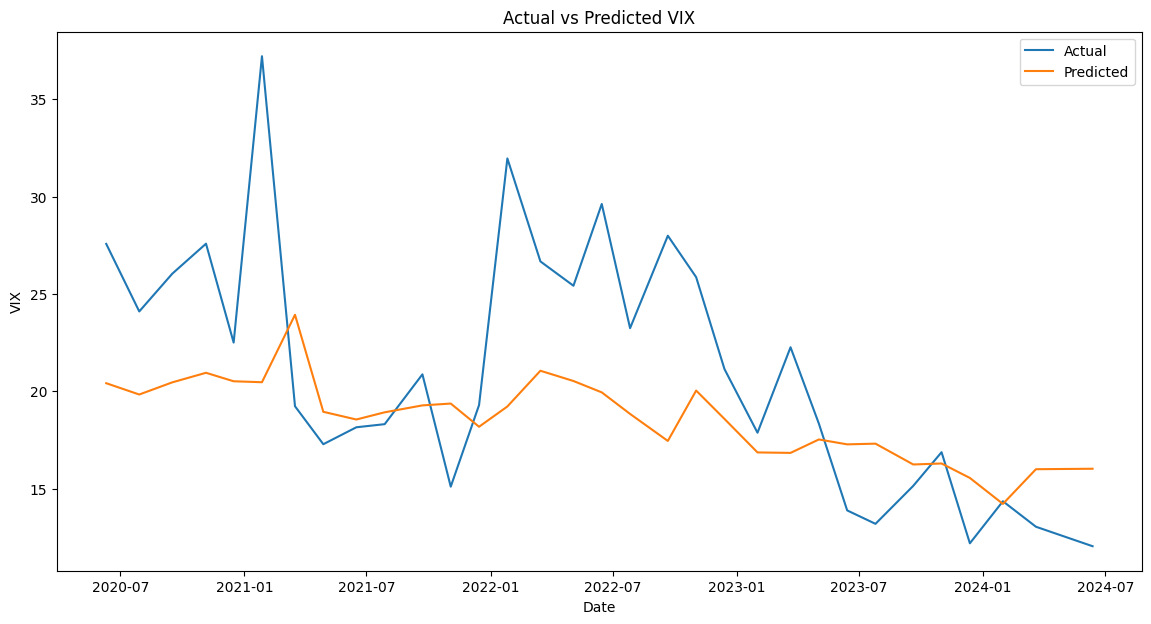

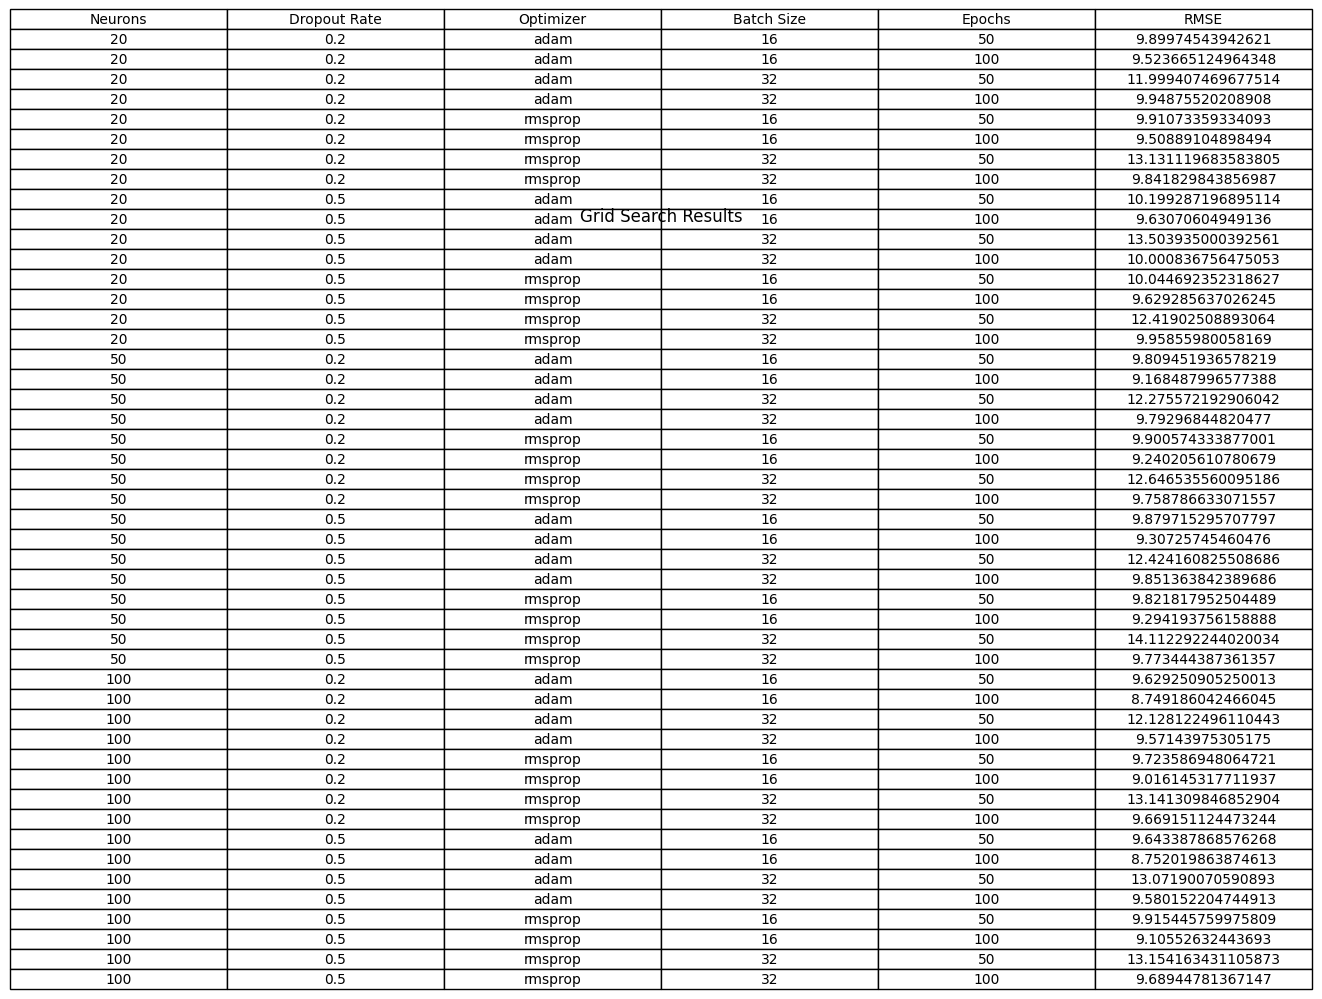

In [7]:
# Function to create the LSTM model
def create_model(neurons=50, dropout_rate=0.2, optimizer='adam'):
    # LSTM for previous VIX values
    input_vix = Input(shape=(X_vix_train.shape[1], X_vix_train.shape[2]))
    lstm_vix = LSTM(neurons, activation='relu')(input_vix)
    dropout_vix = Dropout(dropout_rate)(lstm_vix)

    # Dense layers for topic vectors
    input_topics = Input(shape=(X_topics_train.shape[1],))
    dense_topics = Dense(50, activation='relu')(input_topics)
    dropout_topics = Dropout(dropout_rate)(dense_topics)

    # Concatenate both inputs
    concatenated = concatenate([dropout_vix, dropout_topics])
    output = Dense(1)(concatenated)

    model = Model(inputs=[input_vix, input_topics], outputs=output)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create a custom function to perform grid search
def grid_search_lstm(X_vix_train, X_topics_train, y_train, param_grid, cv=3):
    best_score = float('inf')
    best_params = None
    kfold = KFold(n_splits=cv)
    results = []

    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            for optimizer in param_grid['optimizer']:
                for batch_size in param_grid['batch_size']:
                    for epochs in param_grid['epochs']:
                        scores = []
                        for train_idx, val_idx in kfold.split(X_vix_train):
                            X_vix_train_cv, X_vix_val_cv = X_vix_train[train_idx], X_vix_train[val_idx]
                            X_topics_train_cv, X_topics_val_cv = X_topics_train[train_idx], X_topics_train[val_idx]
                            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
                            
                            model = create_model(neurons=neurons, dropout_rate=dropout_rate, optimizer=optimizer)
                            model.fit([X_vix_train_cv, X_topics_train_cv], y_train_cv, epochs=epochs, batch_size=batch_size, verbose=0)
                            
                            y_pred_val = model.predict([X_vix_val_cv, X_topics_val_cv])
                            score = mean_squared_error(y_val_cv, y_pred_val, squared=False)
                            scores.append(score)
                        
                        avg_score = np.mean(scores)
                        results.append((neurons, dropout_rate, optimizer, batch_size, epochs, avg_score))
                        if avg_score < best_score:
                            best_score = avg_score
                            best_params = {
                                'neurons': neurons,
                                'dropout_rate': dropout_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }
    
    results_df = pd.DataFrame(results, columns=['Neurons', 'Dropout Rate', 'Optimizer', 'Batch Size', 'Epochs', 'RMSE'])
    return best_params, best_score, results_df

# Define the grid search parameters
param_grid = {
    'neurons': [20, 50, 100],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [50, 100] 
}

# Perform grid search
best_params, best_score, results_df = grid_search_lstm(X_vix_train, X_topics_train, y_train, param_grid)
print(f"Best parameters: {best_params}")
print(f"Best score (RMSE): {best_score}")

# Train the final model with the best parameters
final_model = create_model(neurons=best_params['neurons'], dropout_rate=best_params['dropout_rate'], optimizer=best_params['optimizer'])
final_model.fit([X_vix_train, X_topics_train], y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Predict on the test set using the final model
y_pred = final_model.predict([X_vix_test, X_topics_test])

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(merged_data['file_id'][split_index:], y_test, label='Actual')
plt.plot(merged_data['file_id'][split_index:], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Actual vs Predicted VIX')
plt.legend()
plt.show()

# Plot the summary table of all parameters and their scores
plt.figure(figsize=(14, 7))
plt.axis('off')
table = plt.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Grid Search Results')
plt.show()

In [8]:
# Train-test split while respecting the temporal order
split_index = int(len(X_vix_lstm) * 0.8)
X_vix_train, X_vix_test = X_vix_lstm[:split_index], X_vix_lstm[split_index:]
X_topics_train, X_topics_test = X_topics_lstm[:split_index], X_topics_lstm[split_index:]
y_train, y_test = y[:split_index].values, y[split_index:].values  # Convert y to numpy arrays

# Naive Model 1: Last observed VIX value
y_pred_naive1 = y_train[-1] * np.ones_like(y_test)
mae_naive1 = mean_absolute_error(y_test, y_pred_naive1)
rmse_naive1 = mean_squared_error(y_test, y_pred_naive1, squared=False)

print(f'Naive Model 1 - MAE: {mae_naive1}')
print(f'Naive Model 1 - RMSE: {rmse_naive1}')

Naive Model 1 - MAE: 10.5775
Naive Model 1 - RMSE: 11.896769256819265


In [9]:
# Naive Model 2: Using time (previous VIX values) as the only input without any topic models
input_vix_only = Input(shape=(X_vix_train.shape[1], X_vix_train.shape[2]))
lstm_vix_only = LSTM(50, activation='relu')(input_vix_only)
output_vix_only = Dense(1)(lstm_vix_only)
model_vix_only = Model(inputs=input_vix_only, outputs=output_vix_only)
model_vix_only.compile(optimizer='adam', loss='mse')
model_vix_only.fit(X_vix_train, y_train, epochs=50, batch_size=16, verbose=0)
y_pred_naive2 = model_vix_only.predict(X_vix_test)
mae_naive2 = mean_absolute_error(y_test, y_pred_naive2)
rmse_naive2 = mean_squared_error(y_test, y_pred_naive2, squared=False)

print(f'Naive Model 2 - MAE: {mae_naive2}')
print(f'Naive Model 2 - RMSE: {rmse_naive2}')

1/1 [==============================] - 0s 206ms/step
Naive Model 2 - MAE: 18.02796878814697
Naive Model 2 - RMSE: 19.002379613475966


4/4 [==============================] - 0s 10ms/step


Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/32 [00:00<?, ?it/s]

8296/8296 [==============================] - 14s 2ms/step


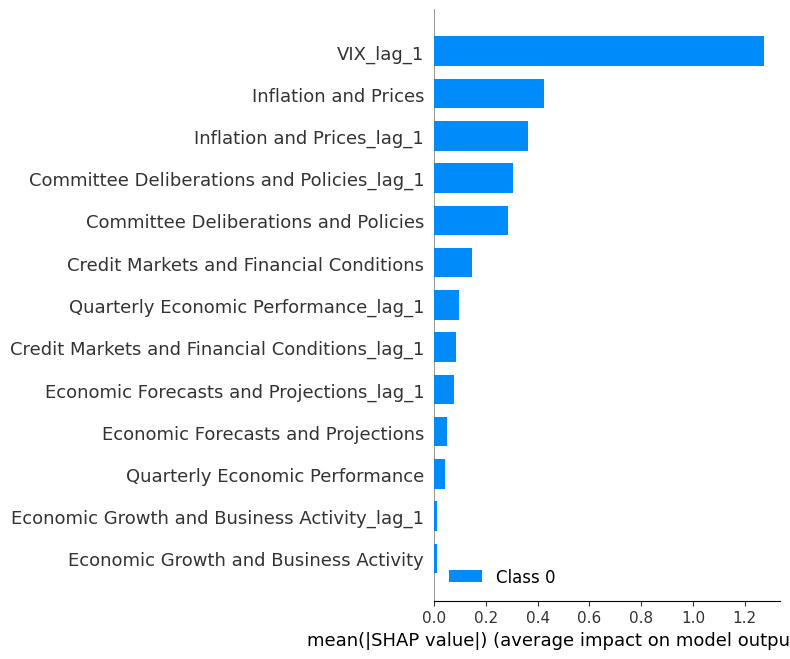

157/157 [==============================] - 0s 2ms/step
Intercept 16.69970834848121
Prediction_local [21.16246037]
Right: 20.41355


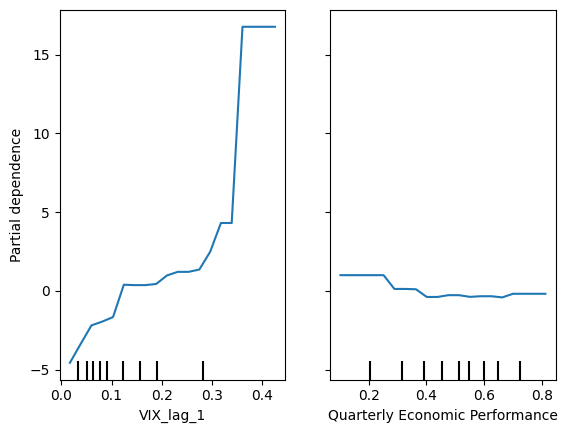

In [19]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay

# Define a wrapper for the model to accept a single input
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        X_vix = X[:, :X_vix_train.shape[2]].reshape((X.shape[0], 1, X_vix_train.shape[2]))
        X_topics = X[:, X_vix_train.shape[2]:]
        return self.model.predict([X_vix, X_topics])

# SHAP Explanation using KernelExplainer
# Create a sample of training data for SHAP background
background = np.concatenate([X_vix_train.reshape(X_vix_train.shape[0], -1), X_topics_train], axis=1)
explainer = shap.KernelExplainer(ModelWrapper(final_model).predict, background)

# Combine the test data for SHAP values
X_test_combined = np.concatenate([X_vix_test.reshape(X_vix_test.shape[0], -1), X_topics_test], axis=1)
shap_values = explainer.shap_values(X_test_combined)

# Summary plot for SHAP values
shap.summary_plot(shap_values, X_test_combined, feature_names=['VIX_lag_1'] + topic_columns)

# LIME Explanation
explainer_lime = LimeTabularExplainer(
    np.concatenate([X_vix_train.reshape(X_vix_train.shape[0], -1), X_topics_train], axis=1),
    feature_names=['VIX_lag_1'] + topic_columns,
    class_names=['VIX'],
    verbose=True,
    mode='regression'
)

# Pick a sample to explain
sample_index = 0
exp = explainer_lime.explain_instance(
    np.concatenate([X_vix_test[sample_index].reshape(-1), X_topics_test[sample_index]]),
    ModelWrapper(final_model).predict,
    num_features=10
)
exp.show_in_notebook(show_table=True)

# Prepare data for PDP (flatten VIX input and combine with topics)
X_train_pdp = np.concatenate([X_vix_train.reshape(X_vix_train.shape[0], -1), X_topics_train], axis=1)
X_test_pdp = np.concatenate([X_vix_test.reshape(X_vix_test.shape[0], -1), X_topics_test], axis=1)

# Train a simple model for PDP (sklearn-compatible)
pdp_model = GradientBoostingRegressor()
pdp_model.fit(X_train_pdp, y_train)

# Plot PDP
features = [0, 1]  # Indexes for VIX_lag_1 and the first topic
PartialDependenceDisplay.from_estimator(pdp_model, X_train_pdp, features, feature_names=['VIX_lag_1'] + topic_columns, grid_resolution=20)
plt.show()


In [20]:
### Backtesting

1/1 [==============================] - 0s 129ms/step


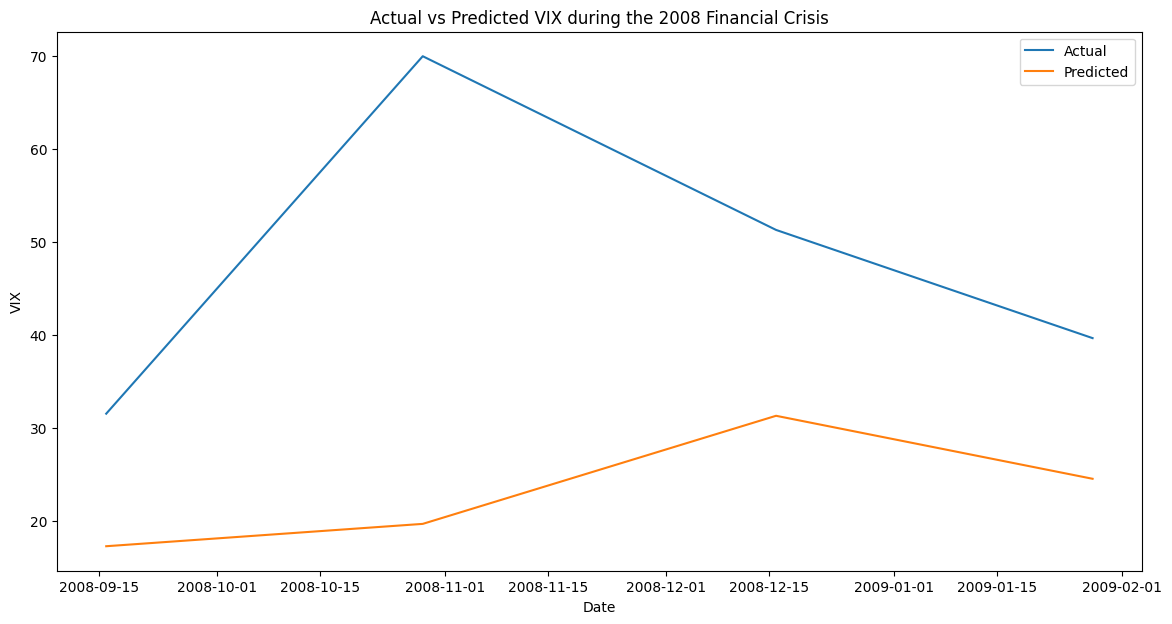

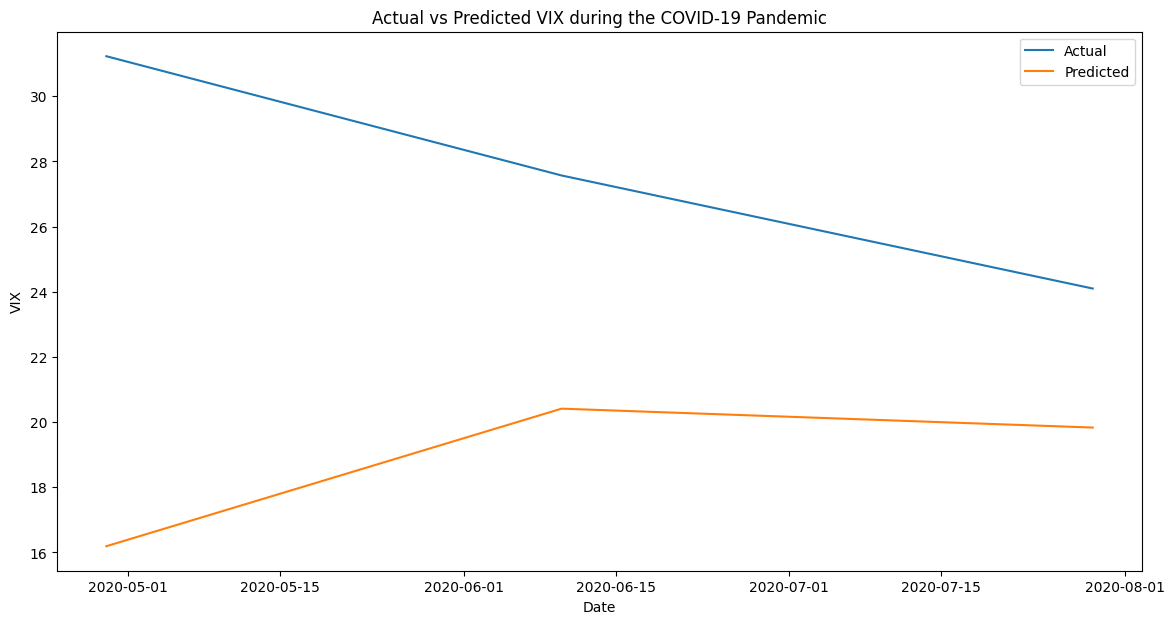

  0%|          | 0/4 [00:00<?, ?it/s]

8296/8296 [==============================] - 9s 1ms/step


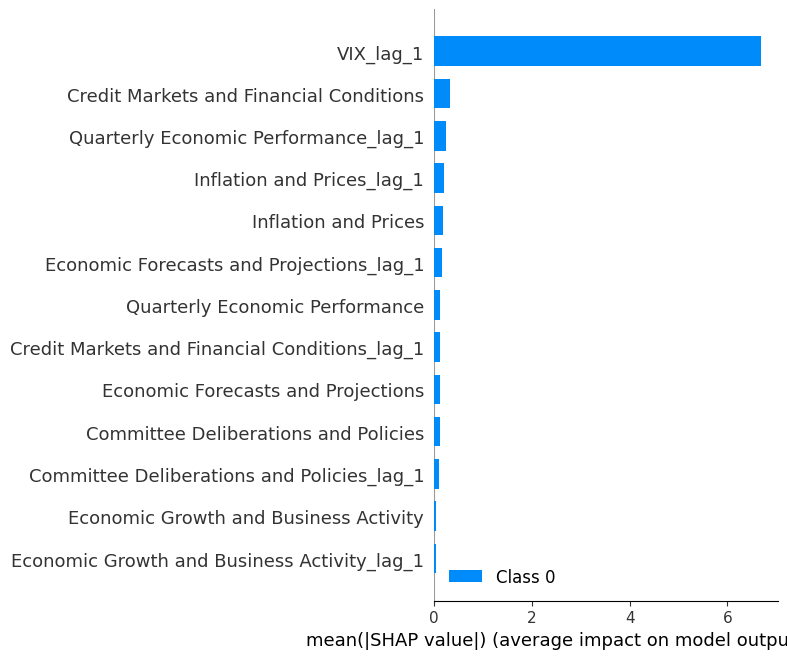

  0%|          | 0/3 [00:00<?, ?it/s]

8296/8296 [==============================] - 9s 1ms/step


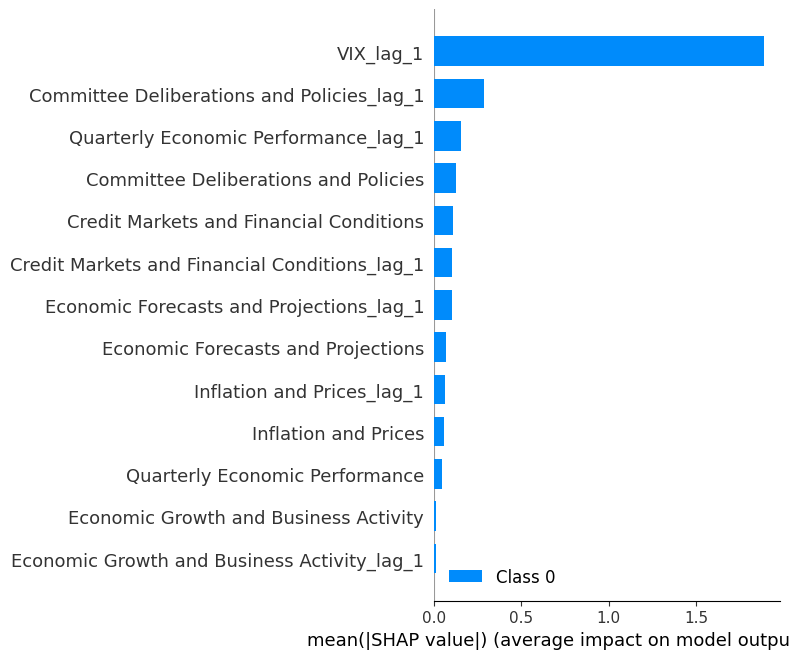

157/157 [==============================] - 0s 2ms/step
Intercept 17.2601741573773
Prediction_local [19.51686695]
Right: 17.293343


157/157 [==============================] - 0s 3ms/step
Intercept 18.215161679660323
Prediction_local [16.6922835]
Right: 16.19143


In [21]:
# Define the periods for the 2008 financial crisis and COVID-19 pandemic
crisis_2008_start = '2008-09-01'
crisis_2008_end = '2009-03-01'
covid_start = '2020-02-01'
covid_end = '2020-08-01'

# Filter the data for the 2008 financial crisis
crisis_2008_mask = (merged_data['file_id'] >= crisis_2008_start) & (merged_data['file_id'] <= crisis_2008_end)
X_vix_crisis_2008 = X_vix_lstm[crisis_2008_mask]
X_topics_crisis_2008 = X_topics_lstm[crisis_2008_mask]
y_crisis_2008 = y[crisis_2008_mask]

# Filter the data for the COVID-19 pandemic
covid_mask = (merged_data['file_id'] >= covid_start) & (merged_data['file_id'] <= covid_end)
X_vix_covid = X_vix_lstm[covid_mask]
X_topics_covid = X_topics_lstm[covid_mask]
y_covid = y[covid_mask]

# Predict on the 2008 financial crisis period
y_pred_crisis_2008 = final_model.predict([X_vix_crisis_2008, X_topics_crisis_2008])

# Predict on the COVID-19 pandemic period
y_pred_covid = final_model.predict([X_vix_covid, X_topics_covid])

# Plot the actual vs predicted values for the 2008 financial crisis
plt.figure(figsize=(14, 7))
plt.plot(merged_data['file_id'][crisis_2008_mask], y_crisis_2008, label='Actual')
plt.plot(merged_data['file_id'][crisis_2008_mask], y_pred_crisis_2008, label='Predicted')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Actual vs Predicted VIX during the 2008 Financial Crisis')
plt.legend()
plt.show()

# Plot the actual vs predicted values for the COVID-19 pandemic
plt.figure(figsize=(14, 7))
plt.plot(merged_data['file_id'][covid_mask], y_covid, label='Actual')
plt.plot(merged_data['file_id'][covid_mask], y_pred_covid, label='Predicted')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('Actual vs Predicted VIX during the COVID-19 Pandemic')
plt.legend()
plt.show()

# SHAP Explanation for the 2008 financial crisis
X_crisis_2008_combined = np.concatenate([X_vix_crisis_2008.reshape(X_vix_crisis_2008.shape[0], -1), X_topics_crisis_2008], axis=1)
shap_values_crisis_2008 = explainer.shap_values(X_crisis_2008_combined)

# Summary plot for SHAP values during the 2008 financial crisis
shap.summary_plot(shap_values_crisis_2008, X_crisis_2008_combined, feature_names=['VIX_lag_1'] + topic_columns)

# SHAP Explanation for the COVID-19 pandemic
X_covid_combined = np.concatenate([X_vix_covid.reshape(X_vix_covid.shape[0], -1), X_topics_covid], axis=1)
shap_values_covid = explainer.shap_values(X_covid_combined)

# Summary plot for SHAP values during the COVID-19 pandemic
shap.summary_plot(shap_values_covid, X_covid_combined, feature_names=['VIX_lag_1'] + topic_columns)

# LIME Explanation for a sample during the 2008 financial crisis
sample_index_crisis_2008 = 0
exp_crisis_2008 = explainer_lime.explain_instance(
    np.concatenate([X_vix_crisis_2008[sample_index_crisis_2008].reshape(-1), X_topics_crisis_2008[sample_index_crisis_2008]]),
    ModelWrapper(final_model).predict,
    num_features=10
)
exp_crisis_2008.show_in_notebook(show_table=True)

# LIME Explanation for a sample during the COVID-19 pandemic
sample_index_covid = 0
exp_covid = explainer_lime.explain_instance(
    np.concatenate([X_vix_covid[sample_index_covid].reshape(-1), X_topics_covid[sample_index_covid]]),
    ModelWrapper(final_model).predict,
    num_features=10
)
exp_covid.show_in_notebook(show_table=True)


2008 Financial Crisis

- VIX_lag_1: The previous VIX value has the highest positive impact. This is expected because during financial crises, the VIX tends to persist at high levels, indicating sustained market volatility.
- Inflation and Prices: Lower inflation rates during the crisis period contributed negatively to the VIX, possibly reflecting deflationary pressures and economic uncertainty.
- Quarterly Economic Performance_lag_1: The lagged economic performance indicators have a notable positive impact, highlighting that past economic conditions are critical in predicting market volatility.
- Credit Markets and Financial Conditions: Tightening credit conditions significantly impact market volatility, reflecting the credit crunch during the crisis.
- Committee Deliberations and Policies: Policies and deliberations from the Federal Reserve play a crucial role, as the crisis prompted significant policy interventions.
- Economic Forecasts and Projections_lag_1: Lagged economic forecasts influence the VIX, indicating that past projections continue to affect market sentiment.

COVID-19 Pandemic
- Committee Deliberations and Policies_lag_1: Similar to the 2008 crisis, past Federal Reserve policies and deliberations play a critical role, reflecting the ongoing influence of policy decisions.
- VIX_lag_1: The previous VIX value remains a strong predictor, indicating persistent volatility during the pandemic.
- Quarterly Economic Performance_lag_1: The lagged economic performance shows a strong positive impact, underscoring the ongoing economic challenges and their influence on market volatility.
- Economic Forecasts and Projections: Current economic forecasts have a significant impact, reflecting the uncertain economic outlook during the pandemic.
- Inflation and Prices: The role of inflation and prices is highlighted again, though the context during COVID-19 might be different, reflecting supply chain disruptions and changing consumption patterns.
- Economic Growth and Business Activity_lag_1: Past economic growth and business activity influence current market sentiment, indicating that previous economic performance sets the stage for current volatility.

In [23]:
import joblib
import tensorflow as tf

# Save the final LSTM model as a HDF5 file
final_model.save('final_lstm_model.h5')

# Save the scaler objects
joblib.dump(scaler_vix, 'lstm_scaler_vix.pkl')
joblib.dump(scaler_topics, 'lstm_scaler_topics.pkl')

# Save the model structure to a JSON file
model_json = final_model.to_json()
with open("lstm_final_lstm_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to a HDF5 file
final_model.save_weights("lstm_final_lstm_model_weights.h5")


### Light Gradient Boosting

In [ ]:
#### IF WE DO JUST LGB:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib

# Load the dataset
sentiment_data = pd.read_csv('Final Sentiment by Topic.csv')

# Convert the date columns to datetime format
sentiment_data['month'] = pd.to_datetime(sentiment_data['month'])
sentiment_data['file_id'] = pd.to_datetime(sentiment_data['file_id'], format='%Y%m%d')

# Create lagged features for each of the topic vectors
for column in sentiment_data.columns[3:]:
    sentiment_data[f'{column}_lag_1'] = sentiment_data[column].shift(1)

# Drop rows with missing values (created by shift operation)
sentiment_data.dropna(inplace=True)

# Define the topic columns
topic_columns = ['Quarterly Economic Performance', 'Committee Deliberations and Policies',
                 'Inflation and Prices', 'Economic Growth and Business Activity',
                 'Credit Markets and Financial Conditions', 'Economic Forecasts and Projections',
                 'Quarterly Economic Performance_lag_1', 'Committee Deliberations and Policies_lag_1',
                 'Inflation and Prices_lag_1', 'Economic Growth and Business Activity_lag_1',
                 'Credit Markets and Financial Conditions_lag_1', 'Economic Forecasts and Projections_lag_1']

# Define features (X) and target (y)
X = sentiment_data[topic_columns]
y = sentiment_data['VIX_lag_1']  # Assuming VIX_lag_1 is the target

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split while respecting the temporal order
split_index = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index].values, y[split_index:].values  # Convert y to numpy arrays

# Train the LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10)

# Predict on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('VIX')
plt.title('Actual vs Predicted VIX')
plt.legend()
plt.show()

# Save the model and the scaler
bst.save_model('lgb_model.txt')
joblib.dump(scaler, 'lgb_scaler.pkl')
